# Proposed Method

Total Frames Acquired: 5960

Processing Frame 1/5960
Convex Hulls Found: 35
Detected 0 blobs
Extracted SIFT Descriptors Shape: (236, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


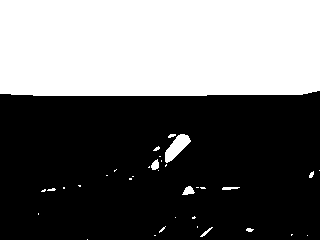


Processing Frame 2/5960
Convex Hulls Found: 35
Detected 0 blobs
Extracted SIFT Descriptors Shape: (230, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


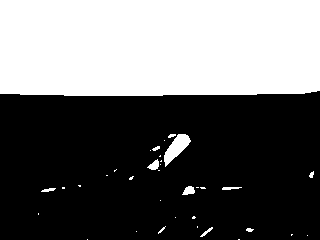


Processing Frame 3/5960
Convex Hulls Found: 38
Detected 0 blobs
Extracted SIFT Descriptors Shape: (248, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


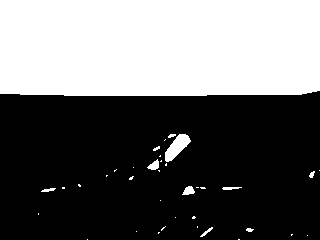


Processing Frame 4/5960
Convex Hulls Found: 37
Detected 0 blobs
Extracted SIFT Descriptors Shape: (248, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


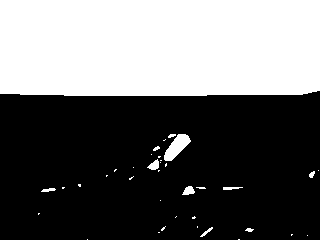


Processing Frame 5/5960
Convex Hulls Found: 42
Detected 0 blobs
Extracted SIFT Descriptors Shape: (252, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


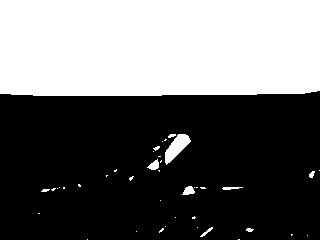


Processing Frame 6/5960
Convex Hulls Found: 40
Detected 0 blobs
Extracted SIFT Descriptors Shape: (252, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


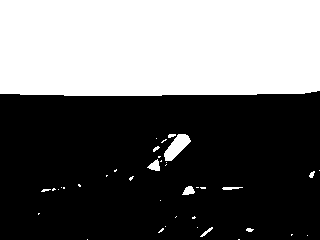


Processing Frame 7/5960
Convex Hulls Found: 40
Detected 0 blobs
Extracted SIFT Descriptors Shape: (249, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


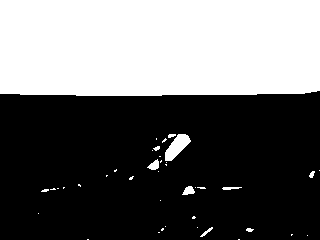


Processing Frame 8/5960
Convex Hulls Found: 41
Detected 0 blobs
Extracted SIFT Descriptors Shape: (245, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


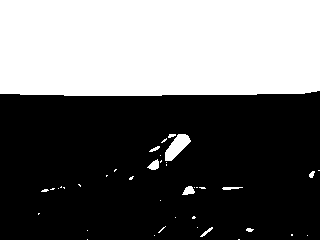


Processing Frame 9/5960
Convex Hulls Found: 43
Detected 0 blobs
Extracted SIFT Descriptors Shape: (254, 128)
Optical Flow Histogram Length: 64
Feature Vector Length: 896


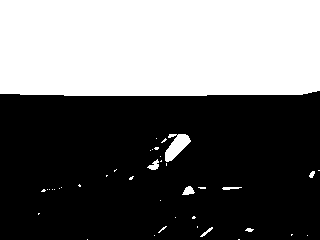

Feature Extraction Complete!
Final Feature Array Shape: (9, 896)


In [ ]:
import cv2
import numpy as np
from skimage.feature import blob_dog, local_binary_pattern
from scipy.stats import skew
from google.colab.patches import cv2_imshow

# --- Step 1: Acquisition of the Image ---
def acquire_image(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

# --- Gabor Filter ---
def apply_gabor_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernels = []
    for theta in range(4):  # Create Gabor kernels at different orientations
        theta = theta * np.pi / 4.0
        kernel = cv2.getGaborKernel(ksize=(21, 21), sigma=5.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
        kernels.append(kernel)
    filtered_images = [cv2.filter2D(gray, cv2.CV_32F, k) for k in kernels]
    combined_gabor = np.max(filtered_images, axis=0)  # Combine all orientations by taking the max response
    return combined_gabor

# --- Step 2: Enhancement ---
def enhance_image(image):
    # Gaussian Filtering for noise reduction
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 0)
    # Sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(gaussian_filtered, -1, kernel)
    return sharpened_image

# --- Step 3 (Updated): Segmentation with Convex Hull ---
def segment_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

def apply_convex_hull(segmented_image):
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hulls = [cv2.convexHull(contour) for contour in contours]
    hull_image = np.zeros_like(segmented_image)
    cv2.drawContours(hull_image, hulls, -1, (255), thickness=cv2.FILLED)
    return hull_image, hulls

# --- Step 4: Feature Recognition (Detecting Blobs) ---
def detect_blobs(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blobs = blob_dog(gray, min_sigma=1, max_sigma=50, threshold=0.2)
    return blobs

# --- Step 5: Feature Extraction (LBP Histogram and Keypoints) ---
def extract_lbp_histogram(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(257), range=(0, 256))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize the histogram
    return hist

def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

# --- Step 6: Representation of Image Features ---
def represent_features(image):
    # Color representation using HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()

    # Texture representation using LBP
    lbp_hist = extract_lbp_histogram(image)

    # Texture representation using Gabor filter
    gabor_filtered = apply_gabor_filter(image)
    gabor_hist, _ = np.histogram(gabor_filtered.ravel(), bins=64, range=(0, 255))
    gabor_hist = gabor_hist.astype("float")
    gabor_hist /= gabor_hist.sum()  # Normalize the histogram

    # Combine all histograms
    combined_features = np.hstack([hsv_hist, lbp_hist, gabor_hist])
    return combined_features

# --- Step 7: Optical Flow for Dynamic Features ---
def compute_optical_flow(prev_frame, next_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Compute dense optical flow using Farneback's method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Use histogram of magnitudes as a dynamic feature representation
    flow_hist, _ = np.histogram(magnitude.ravel(), bins=64, range=(0, 255))
    flow_hist = flow_hist.astype("float")
    flow_hist /= flow_hist.sum()  # Normalize the histogram
    return flow_hist

# --- Main Fire Detection Pipeline ---
def fire_detection_pipeline(video_path):
    frames = acquire_image(video_path)
    print(f"Total Frames Acquired: {len(frames)}")

    feature_vectors = []  # To store the features of each frame

    for i in range(len(frames[:10]) - 1):  # Process first 10 frames for demonstration
        print(f"\nProcessing Frame {i+1}/{len(frames)}")

        frame = frames[i]
        next_frame = frames[i + 1]  # For optical flow computation

        # Step 2: Enhance
        enhanced_frame = enhance_image(frame)

        # Step 3: Segment and apply Convex Hull
        segmented_frame = segment_image(enhanced_frame)
        hull_image, hulls = apply_convex_hull(segmented_frame)
        print(f"Convex Hulls Found: {len(hulls)}")

        # Step 4: Detect Blobs
        blobs = detect_blobs(enhanced_frame)
        print(f"Detected {len(blobs)} blobs")

        # Step 5: Extract Features
        sift_descriptors = extract_sift_features(enhanced_frame)
        print(f"Extracted SIFT Descriptors Shape: {sift_descriptors.shape if sift_descriptors is not None else 'None'}")

        # Step 6: Represent Features
        combined_features = represent_features(enhanced_frame)

        # Step 7: Compute Optical Flow
        flow_hist = compute_optical_flow(frame, next_frame)
        print(f"Optical Flow Histogram Length: {len(flow_hist)}")

        # Combine static and dynamic features
        combined_features = np.hstack([combined_features, flow_hist])
        feature_vectors.append(combined_features)
        print(f"Feature Vector Length: {len(combined_features)}")

        # Visualization (optional)
        cv2_imshow(hull_image)

        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # cv2.destroyAllWindows()
    print("Feature Extraction Complete!")
    return np.array(feature_vectors)

# Run the Pipeline
video_path = "/content/20090409 ManavgatTEst.mp4"  # Replace with your video path
features = fire_detection_pipeline(video_path)
print(f"Final Feature Array Shape: {features.shape}")
